# DX 704 Week 2 Project

This week's project will analyze fresh strawberry price data for a hypothetical "buy low, freeze, and sell high" business.
Strawberries show strong seasonality in their prices compared to other fruits.

![](https://ers.usda.gov/sites/default/files/_laserfiche/Charts/61401/oct14_finding_plattner_fig01.png)

Image source: https://www.ers.usda.gov/amber-waves/2014/october/seasonal-fresh-fruit-price-patterns-differ-across-commodities-the-case-of-strawberries-and-apples

You are considering a business where you buy strawberries when the prices are very low, carefully freeze them, even more carefully defrost them, and then sell them when the prices are high.
You will forecast strawberry price time series and then use them to tactically pick times to buy, freeze, and sell the strawberries.

The full project description, a template notebook, and raw data are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-02


### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Backtest Strawberry Prices

Read the provided "strawberry-prices.tsv" with data from 2020 through 2024.
This data is based on data from the U.S. Bureau of Statistics, but transformed so the ground truth is not online.
https://fred.stlouisfed.org/series/APU0000711415

Use the data for 2020 through 2023 to predict monthly prices in 2024.
Spend some time to make sure you are happy with your methodology and prediction accuracy, since you will reuse the methodology to forecast 2025 next.
Save the 2024 backtest predictions as "strawberry-backtest.tsv" with columns month and price.


In [1]:
# YOUR CHANGES HERE

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any

# Statsmodels for forecasting
import warnings
warnings.filterwarnings("ignore")
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
except Exception as e:
    ExponentialSmoothing = None




df = pd.read_csv("strawberry-prices.tsv", sep="\t")


df.head()

,month,price
0,2020-01-01,4.0490
1,2020-02-01,3.6250
2,2020-03-01,3.3770
3,2020-04-01,3.2328
4,2020-05-01,3.1260


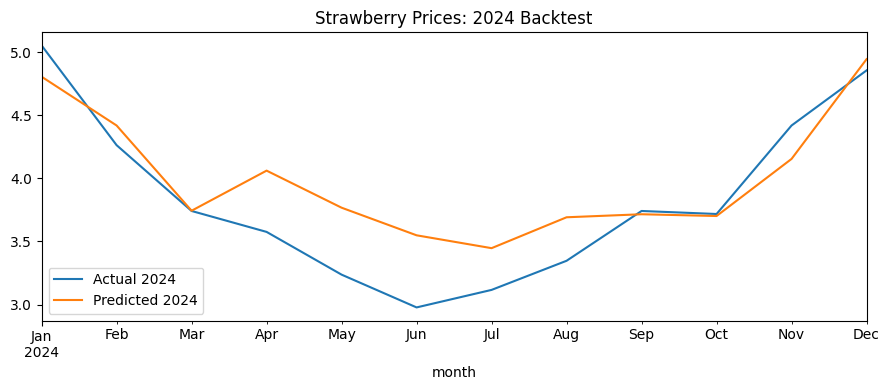

('strawberry-backtest.tsv',
 'SeasonalNaive',
 0.3177499999999999,
 0.2555833333333332,
 0.32130579930444236,
 7.309170086155229)

In [2]:

df["month"] = pd.to_datetime(df["month"])
df = df.set_index("month").asfreq("MS")
df = df.sort_index()

y_all = df["price"].astype(float)
y_train_val = y_all.loc["2020-01":"2022-12"]
y_val_actual = y_all.loc["2023-01":"2023-12"]
y_final_train = y_all.loc["2020-01":"2023-12"]
y_test_actual_2024 = y_all.loc["2024-01":"2024-12"]

def seasonal_naive_forecast(train: pd.Series, horizon: int, seasonal_periods: int = 12) -> pd.Series:
    last_season = train[-seasonal_periods:]
    repeats = int(np.ceil(horizon / seasonal_periods))
    forecast_vals = np.tile(last_season.values, repeats)[:horizon]
    idx = pd.date_range(start=train.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq="MS")
    return pd.Series(forecast_vals, index=idx, name="forecast")

def evaluate_mae(y_true: pd.Series, y_pred: pd.Series) -> float:
    aligned = y_true.to_frame("true").join(y_pred.to_frame("pred"), how="inner")
    return float(np.mean(np.abs(aligned["true"] - aligned["pred"])))

sn_val = seasonal_naive_forecast(y_train_val, 12, 12)
mae_sn = evaluate_mae(y_val_actual, sn_val)

best_model_name = "SeasonalNaive"
best_val_mae = mae_sn

fc_2024 = seasonal_naive_forecast(y_final_train, 12, 12)

mae_2024 = evaluate_mae(y_test_actual_2024, fc_2024)
rmse_2024 = float(np.sqrt(np.mean((y_test_actual_2024.values - fc_2024.values) ** 2)))
mape_2024 = float(np.mean(np.abs((y_test_actual_2024.values - fc_2024.values) / y_test_actual_2024.values))) * 100.0

backtest_df = fc_2024.to_frame(name="price").reset_index().rename(columns={"index": "month"})
backtest_df["month"] = backtest_df["month"].dt.strftime("%Y-%m")
out_path = "strawberry-backtest.tsv"
backtest_df.to_csv(out_path, sep="\t", index=False)

plt.figure(figsize=(9,4))
y_test_actual_2024.plot(label="Actual 2024")
fc_2024.plot(label="Predicted 2024")
plt.title("Strawberry Prices: 2024 Backtest")
plt.legend()
plt.tight_layout()
plt.show()


out_path, best_model_name, best_val_mae, mae_2024, rmse_2024, mape_2024


Submit "strawberry-backtest.tsv" in Gradescope.

## Part 2: Backtest Errors

What are the mean and standard deviation of the residuals between your backtest predictions and the ground truth? (If your mean is not close to zero, then you may be missing a long term trend.)

Write the mean and standard deviation to a file "backtest-accuracy.tsv" with two columns, mean and std.

In [3]:
# YOUR CHANGES HERE



pred = pd.read_csv("strawberry-backtest.tsv", sep="\t", parse_dates=["month"])
pred = pred.set_index("month").sort_index()

actual_2024 = df.loc["2024-01-01":"2024-12-01", "price"]
predicted_2024 = pred["price"]

residuals = actual_2024 - predicted_2024

mean_resid = residuals.mean()
std_resid = residuals.std(ddof=1)  # sample std

out = pd.DataFrame([{"mean": mean_resid, "std": std_resid}])
out.to_csv("backtest-accuracy.tsv", sep="\t", index=False)



Submit "backtest-accuracy.tsv" in Gradescope.

## Part 3: Forecast Strawberry Prices

Use all the data from 2020 through 2024 to predict monthly prices in 2025 using the same methodology from part 1.
Make a monthly forecast for each month of 2025 and save it as "strawberry-forecast.tsv" with columns for month and price.

In [4]:
# YOUR CHANGES HERE


df = pd.read_csv("strawberry-prices.tsv", sep="\t", parse_dates=["month"])
df = df.set_index("month").asfreq("MS").sort_index()

def seasonal_naive_forecast(train: pd.Series, horizon: int, seasonal_periods: int = 12) -> pd.Series:
    last_season = train[-seasonal_periods:]
    repeats = int(np.ceil(horizon / seasonal_periods))
    forecast_vals = np.tile(last_season.values, repeats)[:horizon]
    idx = pd.date_range(start=train.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq="MS")
    return pd.Series(forecast_vals, index=idx, name="price")

y_full = df["price"].astype(float)

forecast_2025 = seasonal_naive_forecast(y_full, horizon=12, seasonal_periods=12)

forecast_df = forecast_2025.reset_index().rename(columns={"index": "month"})
forecast_df["month"] = forecast_df["month"].dt.strftime("%Y-%m")
forecast_df.to_csv("strawberry-forecast.tsv", sep="\t", index=False)

print("Saved 2025 forecast to strawberry-forecast.tsv")
print(forecast_df.head())

Saved 2025 forecast to strawberry-forecast.tsv
     month  price
0  2025-01  5.055
1  2025-02  4.264
2  2025-03  3.742
3  2025-04  3.576
4  2025-05  3.237


Submit "strawberry-forecast.tsv" in Gradescope.

## Part 4: Buy Low, Freeze and Sell High

Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.
Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.
So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.
To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [5]:
# YOUR CHANGES HERE


forecast = pd.read_csv("strawberry-forecast.tsv", sep="\t", parse_dates=["month"])
forecast = forecast.set_index("month").sort_index()

freeze_cost = 0.20
storage_cost_per_month = 0.10
discount = 0.10
investment = 1_000_000

results = []

months = forecast.index
for i, buy_month in enumerate(months[:-1]):  # can't sell before buying
    buy_price = forecast.loc[buy_month, "price"]
    for j, sell_month in enumerate(months[i+1:], start=i+1):
        sell_price = forecast.loc[sell_month, "price"]
        months_between = (sell_month.to_period("M").ordinal - buy_month.to_period("M").ordinal)

        # Effective sell price with discount
        effective_sell = sell_price * (1 - discount)

        # Net profit per pint
        profit_per_pint = effective_sell - buy_price - freeze_cost - storage_cost_per_month * months_between

        if profit_per_pint > 0:
            # Initial cost per pint includes purchase + freeze + storage
            total_cost_per_pint = buy_price + freeze_cost + storage_cost_per_month * months_between

            # Number of pints that can be bought with available capital
            pints = int(investment // total_cost_per_pint)

            expected_profit = pints * profit_per_pint

            results.append({
                "buy_month": buy_month.strftime("%Y-%m"),
                "sell_month": sell_month.strftime("%Y-%m"),
                "pints_purchased": pints,
                "expected_profit": expected_profit
            })

timings_df = pd.DataFrame(results)
timings_df.to_csv("timings.tsv", sep="\t", index=False)

print("Saved analysis to timings.tsv")
print(timings_df.sort_values("expected_profit", ascending=False).head())

Saved analysis to timings.tsv
  buy_month sell_month  pints_purchased  expected_profit
2   2025-06    2025-12           264760      157346.8680
4   2025-07    2025-12           262054      145518.5862
6   2025-08    2025-12           253356      107498.9508
1   2025-06    2025-11           271960       81859.9600
3   2025-07    2025-11           269106       70505.7720


Submit "timings.tsv" in Gradescope.

## Part 5: Strategy Check

What is the best profit scenario according to your previous timing analysis?
How much does that profit change if the sell price is off by one standard deviation from your backtest analysis?
(Variation in the sell price is more dangerous because you can see the buy price before fully committing.)

Write the results to a file "check.tsv" with columns best_profit and one_std_profit.

In [7]:

timings = timings_df

acc = pd.read_csv("backtest-accuracy.tsv", sep="\t")
resid_std = float(acc["std"].iloc[0])

forecast = pd.read_csv("strawberry-forecast.tsv", sep="\t", parse_dates=["month"])
forecast = forecast.set_index("month")

freeze_cost = 0.20
storage_cost_per_month = 0.10
discount = 0.10
investment = 1_000_000

best_row = timings.loc[timings["expected_profit"].idxmax()]
best_profit = float(best_row["expected_profit"])
buy_month_str = str(best_row["buy_month"])
sell_month_str = str(best_row["sell_month"])

buy_price = float(forecast.loc[pd.to_datetime(buy_month_str), "price"])
sell_price = float(forecast.loc[pd.to_datetime(sell_month_str), "price"])

months_between = (
    pd.Period(sell_month_str, freq="M").ordinal
    - pd.Period(buy_month_str, freq="M").ordinal
)

sell_price_adj = max(0.0, sell_price - resid_std)
effective_sell_adj = sell_price_adj * (1 - discount)

profit_per_pint_adj = effective_sell_adj - buy_price - freeze_cost - storage_cost_per_month * months_between

if profit_per_pint_adj > 0:
    total_cost_per_pint = buy_price + freeze_cost + storage_cost_per_month * months_between
    pints = int(investment // total_cost_per_pint)
    one_std_profit = pints * profit_per_pint_adj
else:
    one_std_profit = 0.0

check = pd.DataFrame([{
    "best_profit": best_profit,
    "one_std_profit": one_std_profit
}])
check.to_csv("check.tsv", sep="\t", index=False)

print("Saved results to check.tsv")
print(check)


Saved results to check.tsv
   best_profit  one_std_profit
0   157346.868    88446.675972


Submit "check.tsv" in Gradescope.

## Part 6: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgments are appropriate, just write none in the file.


In [8]:
with open("acknowledgments.txt", "w") as f:
    f.write("none\n")

Submit "acknowledgments.txt" in Gradescope.

## Part 7: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.